<a href="https://colab.research.google.com/github/llazzari/Cats-and-dogs-classifier/blob/main/Cats_and_dogs_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning basics: transfer learning / fine-tuning

This project is part of the DIO/BairesDev bootcamp: Machine Learning practitioner. It aims to develop an accurate image classifier from a relatively small number of training samples. We will start by developing a neural network from scratch using the Keras module. Then, we will apply the concept of transfer learning, where we will use as the base model called VGG16 image classifier applied to our problem.

In [1]:
%matplotlib inline

import os
import io

#if using Theano with GPU
# os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image, ImageFile, UnidentifiedImageError

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Normalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

## Dataset handling

In this section, we will download the Microsoft Cats and Dogs dataset from Kaggle.

In [2]:
!curl -L -o catsvsdogs.zip --progress-bar --output ~/Downloads/microsoft-catsvsdogs-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/shaunthesheep/microsoft-catsvsdogs-dataset
!unzip -q catsvsdogs.zip
!rm catsvsdogs.zip
!ls

############################################################################################# 100.0%
'MSR-LA - 3467.docx'   PetImages  'readme[1].txt'   sample_data


In [3]:
root: str = 'PetImages'

categories: list[str] = ['PetImages/Cat', 'PetImages/Dog']

The images are going to be preprocessed with the help of the function get_image, where they will be resized to (224, 224) in order to match the input dimensions required by the pre-trained VGG16 model.

In [4]:
def get_image(path):
    """Helper function to preprocess images."""
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

To avoid reaching Colab's computational limit, we will use 2800 images in total, 1400 for each category. We will append only valid images to the data list that's going to be used from now on.

In [5]:
data = []
for c, category in enumerate(categories):
    images = [
        os.path.join(dp, f) for dp, dn, filenames
        in os.walk(category) for f in filenames
        if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']
    ]
    images = images[:1400] # limits the amount of images
    for img_path in images:
        try:
            img, x = get_image(img_path)
            data.append({'x': np.array(x[0]), 'y': c})
        except (FileNotFoundError, UnidentifiedImageError, OSError):
            print(f'Skipping corrupted image: {img_path}')
            continue

num_classes = len(categories)

Skipping corrupted image: PetImages/Dog/11702.jpg


Randomize the data order.

In [6]:
random.shuffle(data)

The data will be split in three parts: train (70%), test (15%) and validation (15%).  

In [7]:
train_split: float = 0.7
val_split: float = 0.15

idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

In [8]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 

Normalization is applied to scale pixel values to the range [0, 1], improving numerical stability during training.

In [9]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(420, 2)


In [10]:
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 2799 images from 2 categories
train / validation / test split: 1959, 420, 420
training data shape:  (1959, 224, 224, 3)
training labels shape:  (1959, 2)


Here we present a sample of the images.

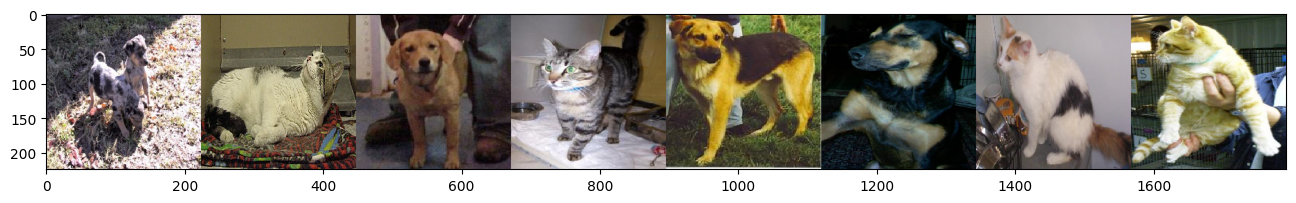

In [11]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Building a CNN from scratch

A simple Convulotional Neural Network (CNN) is built from scratch to establish a baseline performance. This helps us to understand how well a model performs without leveraging external pre-trained knowledge and to appreatiate the added value of pre-trained models.

The model uses Conv2D layers for feature extraction, MaxPooling2D layers for down-sampling, and Dense layers for classification.

In [12]:
model = Sequential()
print("Input dimensions: ", x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model to use categorical cross-entropy as the loss function, the adam optimizer and the accuracy as the evaluation metric.

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5159 - loss: 0.7125 - val_accuracy: 0.5452 - val_loss: 0.6897
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.5727 - loss: 0.6726 - val_accuracy: 0.5833 - val_loss: 0.6632
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.6185 - loss: 0.6410 - val_accuracy: 0.5976 - val_loss: 0.6592
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.6619 - loss: 0.6233 - val_accuracy: 0.5976 - val_loss: 0.6514
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.6492 - loss: 0.6158 - val_accuracy: 0.6143 - val_loss: 0.6386
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6840 - loss: 0.5904 - val_accuracy: 0.6357 - val_loss: 0.6322
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6998 - loss: 0.5535 - val_accuracy: 0.6381 - val_loss: 0.6281
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.7609 - loss: 0.4999 - val_accuracy: 0.6

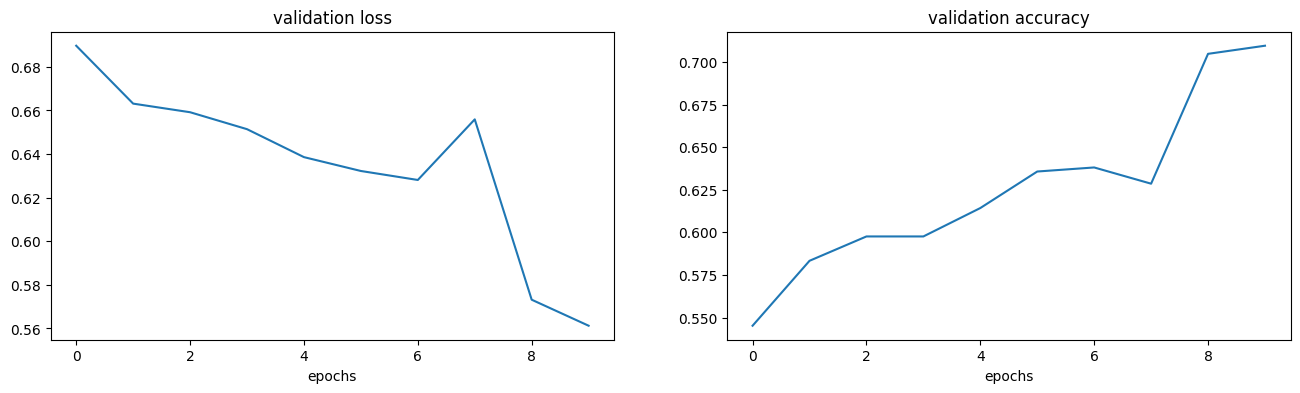

In [14]:
def make_validation_plots(histories: list) -> None:
    """Helper function to plot validation metrics."""
    def plot_val_(metric: str, ax, histories: list):
        for history in histories:
            ax.plot(history.history[metric])
        ax.set_xlabel("epochs")
        return ax

    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(121)
    ax.set_title("validation loss")
    ax = plot_val_("val_loss", ax, histories)

    ax2 = fig.add_subplot(122)
    ax2.set_title("validation accuracy")
    ax2 = plot_val_("val_accuracy", ax2, histories)

    plt.show()

make_validation_plots([history])

In [15]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.5538009405136108
Test accuracy: 0.7214285731315613


Our CNN built from scratch and without making any optimizations achieved 72% accuracy in test dataset. This will serve as a benchmark for the following work with Transfer Learning.

## Transfer learning
Transfer learning allows us to use a pre-trained model (VGG16, trained on ImageNet) as a feature extractor. We chose the VGG16 because it is a widely used architecture pre-trained on the large ImageNet dataset. Its deep architecture (16 layers) captures complex feature hierarchies, making it ideal for image classification tasks. The model's simplicity and modularity makes it easy to adapt for transfer learning.

The pre-trained layers capture general image features like edges, textures, and shapes.

In [16]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 25s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

By freezing the pre-trained layers, we ensure that these general features are retained.

Fine-tuning only adjusts the new classification layers, enabling the model to adapt to our specific dataset (cats vs. dogs).

In [18]:
number_of_trainable_layers: int = 1

# make all layers untrainable by freezing weights (except for the last layers)
for layer in model_new.layers[:-number_of_trainable_layers]:
    layer.trainable = False

# ensure the last layers are trainable/not frozen
for layer in model_new.layers[-number_of_trainable_layers:]:
    layer.trainable = True

model_new.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [19]:
history_transfer = model_new.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.5233 - loss: 0.9453 - val_accuracy: 0.7143 - val_loss: 0.5392
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 702ms/step - accuracy: 0.8167 - loss: 0.4711 - val_accuracy: 0.8143 - val_loss: 0.4272
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 729ms/step - accuracy: 0.8548 - loss: 0.3822 - val_accuracy: 0.8429 - val_loss: 0.3790
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 722ms/step - accuracy: 0.8855 - loss: 0.3270 - val_accuracy: 0.8429 - val_loss: 0.3487
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 747ms/step - accuracy: 0.8895 - loss: 0.3045 - val_accuracy: 0.8429 - val_loss: 0.3351
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 745ms/step - accuracy: 0.8994 - loss: 0.2892 - val_accuracy: 0.8667 - val_loss: 0.3078
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 713ms/step - accuracy: 0.9043 - loss: 0.2696 - val_accuracy: 0.8738 - val_loss: 0.2950
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 729ms/step - accuracy: 0.9123 - loss: 0.2553 - val_accurac

Training and validation loss/accuracy are plotted to observe model convergence.
This helps identify potential issues like overfitting or underfitting.

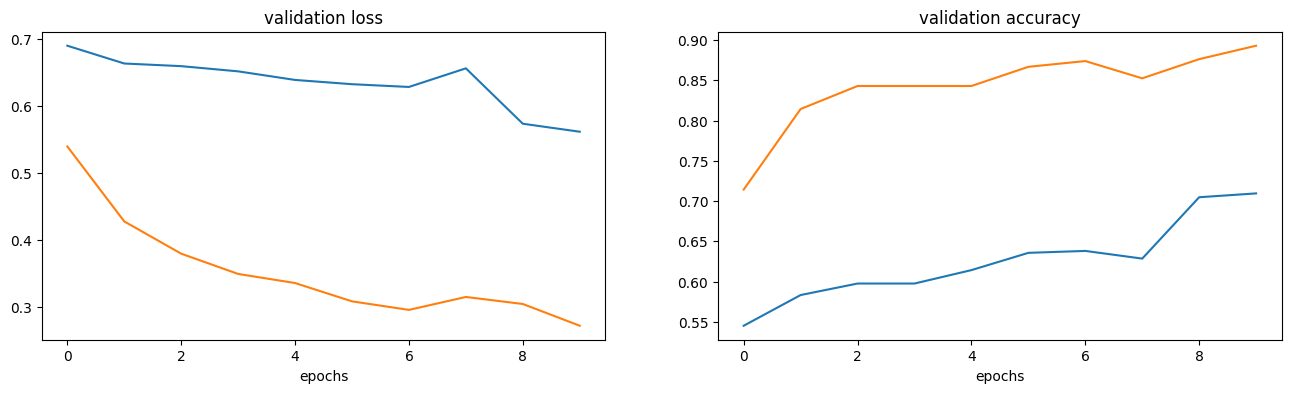

In [20]:
make_validation_plots([history, history_transfer])

In [21]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.2327183336019516
Test accuracy: 0.9071428775787354


The accuracy increased to 91% using the VGG16 pre-trained model! This is the beauty of transfer learning, with minimal adjustments we were able to obtain a 24% increase in accuracy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Dog


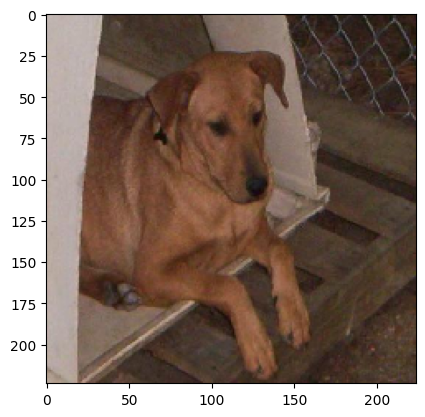

In [22]:
img, x = get_image('/content/PetImages/Dog/100.jpg')
# img, x = get_image('/content/sig.jpg')
plt.imshow(img)
probabilities = model_new.predict([x])
print(f"Prediction: {'Dog' if probabilities[0][1] > 0.5 else 'Cat'}")